Collecting Network Statistics in Pytorch
===

This is adapted from the workbook provided alongside the article "Implementing an Autoencoder in Pytorch" which can be found [here](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1). The purpose is to load generated trained models from the Autoencoder implementation and collect encoding statistics for analysis.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import math

from model import SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder
from CustomDataSet import CustomDataSet
import os

import GPUtil

Set our seed and other configurations for reproducibility.

In [2]:
#seed = 42
seed = 2662
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
#platform = "cpu"
print(platform)

cuda


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 512
height = 512

image_size = width * height

batch_size = 2

#meta-parameters
l2_decay = 0.0
dropout_rate = 0.1
code_sides = [12]
convolution_filters = 16

model_path = "../../Data/OPTIMAM_NEW/model" + str(width) + "_" + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay) + ".pt"

#image_count = 500
image_count = -1

## Dataset

ImageFolder is used to load the base distribution images. This version of the DataLoader setup is designed to not batch or shuffle the images as we load them sequentially

In [4]:
from torchvision.transforms import ToTensor,Grayscale
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.0,65535.0)
    ])

root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/"+str(width)
train_dataset = CustomDataSet(root_dir, transform)
if (image_count == -1):
    train_dataset_subset = train_dataset
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))
    
train_loader = torch.utils.data.DataLoader(
    train_dataset_subset, shuffle=False
)


In [5]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)

# reload the saved model

model = torch.load(model_path,map_location=device)
model.eval()

code_size = code_sides[0] * code_sides[0]

# mean-squared error loss
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

losses = [None] * len(train_dataset_subset)
encodings = [None] * len(train_dataset_subset)

We run our autoencoder on the entire dataset and store the encodings

In [6]:
with torch.no_grad():
    count = 0
    for batch_features in train_loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # compute reconstructions
        code = model.encoder(batch_features)
        outputs = model.decoder(code)
        
        code_reshaped = code.detach().cpu().numpy()[0]
        code_reshaped.reshape(code_size)

        encodings[count] = code_reshaped

        # compute training reconstruction loss
        error_criterion = criterion(outputs,batch_features)

        losses[count] = error_criterion.cpu().numpy()

        count = count + 1

C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


And calculate the encoding statistics:

In [7]:
print(len(encodings))
print(len(encodings[0]))
print(len(losses))

3677
144
3677


In [8]:
feature_means = np.mean(encodings,axis=0)
feature_stds = np.std(encodings,axis=0)
print(len(feature_means))
print(len(feature_stds))

mse_min = np.amin(losses)
mse_max = np.amax(losses)
mse_mean = np.mean(losses)
print("MSE Min/Mean/Max:" + str(mse_min) + "/" + str(mse_mean) + "/" + str(mse_max))

144
144
MSE Min/Mean/Max:0.0022924715/0.0095402/0.12030506


Now we save the compiled statistics to an excel file.

In [9]:
with torch.no_grad():
    np_losses = np.asarray(losses)

    np_compiled = np.concatenate((np_losses[:, np.newaxis], encodings), axis=1)

    np.savetxt('encodings.csv', encodings, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('losses.csv', np_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('combined.csv', np_compiled, delimiter=',',fmt='%10.5f',newline='\n')

## Adversarials

The next stage is to create a set of adversarial images. For this, we will use the same custom dataset as before. However, we will use a different Transform stack - with the same basic elements, plus a set of transforms intended to generate aberrational images.

In [10]:
with torch.no_grad():
    trigger_chance = 0.8

    PIL_transforms = torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=15,translate=(0.4,0.4),shear=60),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.GaussianBlur(kernel_size=5),
        torchvision.transforms.ColorJitter(brightness=0.8,contrast=0.8)
        ],p=trigger_chance)

    adversarial_transform = torchvision.transforms.Compose([
        PIL_transforms,
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(0.0,65535.0),
         torchvision.transforms.RandomErasing(p=trigger_chance),
        ])

    adversarial_image_count = 5
    adversarial_dataset = CustomDataSet(root_dir, adversarial_transform)
    
    adversarial_subset = torch.utils.data.Subset(adversarial_dataset, np.random.choice(len(adversarial_dataset), adversarial_image_count, replace=False))

    adversarial_loader = torch.utils.data.DataLoader(
        adversarial_subset, batch_size=1, shuffle=True
    )
    
    adv_example_sets = np.zeros((5,height,width))
    adv_code_sets = np.zeros((5,code_size))
    reconstruction_sets = np.zeros((5,height,width))

Now run the model on these adversarial images:

In [11]:
with torch.no_grad():
    i = 0
    for batch_features in adversarial_loader:
        batch_features = batch_features
        adv_example = batch_features.to(device)
        n_code = model.encoder(adv_example)
        reconstruction = model(adv_example)
    
        adv_example_sets[i] = adv_example.cpu()
        adv_code_sets[i] = n_code.cpu()
        reconstruction_sets[i] = reconstruction.cpu()
        i += 1

Next, measure the loss and feature statistics for the adversarials:            

In [12]:
mse_array = ((reconstruction_sets - adv_example_sets)**2)
mse = np.apply_over_axes(np.mean, mse_array, (1, 2))
print(len(mse))
print(mse)
#sum_mse = np.sum(mse[0])
#print(sum_mse)

5
[[[0.00289924]]

 [[0.00289929]]

 [[0.0028991 ]]

 [[0.02945458]]

 [[0.0028992 ]]]


In [13]:
g = np.ma.masked_equal(feature_stds,0)

adv_divergence = (adv_code_sets - feature_means) / g
print(np.max(adv_divergence,axis=1))

[3.5504724921429447 3.550466216500449 3.5504634709068568 2.983260985487156
 3.5504714135168904]


And plot the results:

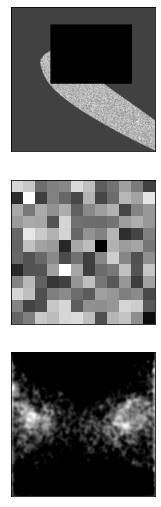

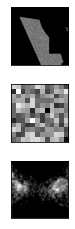

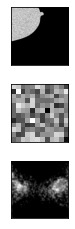

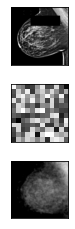

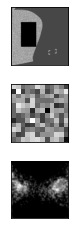

In [14]:
with torch.no_grad():
    number = 5
    plt.figure(figsize=(25, 9))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        test_examples = adv_example_sets
        copyback = test_examples[index]
        plt.imshow(copyback.reshape(height, width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + 1 + number)
        codes = adv_code_sets
        code_copyback = codes[index]
        plt.imshow(code_copyback.reshape(code_sides[0],code_sides[0]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + 6 + number)
        reconstruction = reconstruction_sets
        recon_copyback = reconstruction[index]
        plt.imshow(recon_copyback.reshape(height, width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        out_path = "adv_output"+ str(width) + "_"  + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay) +".png"
        plt.savefig(out_path)
        plt.show()

## Adversarials

To this we will add a set of 5 pre-selected images intended as examples of non-mammographic imagery, to determine how well the algorithm can detect these.

In [21]:
with torch.no_grad():
    aimg_dir = "../../Data/NonMammo/"

    aimg_dataset = CustomDataSet(aimg_dir, transform)
    
    aimg_subset = torch.utils.data.Subset(aimg_dataset, np.random.choice(len(aimg_dataset), 5, replace=False))

    aimg_loader = torch.utils.data.DataLoader(
        aimg_subset, batch_size=1, shuffle=False
    )
    
    adv_example_sets = np.zeros((5,height,width))
    adv_code_sets = np.zeros((5,code_size))
    reconstruction_sets = np.zeros((5,height,width))
    
    print(len(aimg_dataset))

5


In [22]:
with torch.no_grad():
    i = 0
    for batch_features in aimg_loader:
        adv_example = batch_features.to(device)
        n_code = model.encoder(adv_example)
        reconstruction = model(adv_example)
    
        adv_example_sets[i] = adv_example.cpu()
        adv_code_sets[i] = n_code.cpu()
        reconstruction_sets[i] = reconstruction.cpu()
        i += 1

0
512
1
512
2
512
3
512
4
512


In [23]:
mse_array = ((reconstruction_sets - adv_example_sets)**2)
mse = np.apply_over_axes(np.mean, mse_array, (1, 2))
print(len(mse))
print(mse)
#sum_mse = np.sum(mse[0])
#print(sum_mse)

5
[[[0.00281448]]

 [[0.00284418]]

 [[0.00277854]]

 [[0.00286631]]

 [[0.00281071]]]


In [24]:
g = np.ma.masked_equal(feature_stds,0)

adv_divergence = (adv_code_sets - feature_means) / g
print(np.max(adv_divergence,axis=1))

[3.5451724178844435 3.5466439579928104 3.5437732437786074
 3.547928699680011 3.542209726284911]


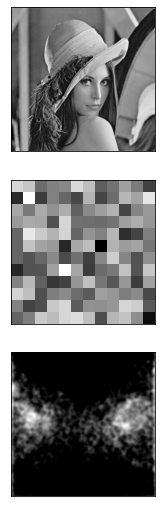

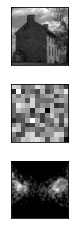

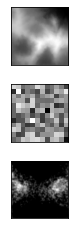

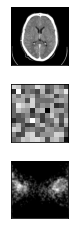

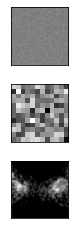

In [25]:
with torch.no_grad():
    number = 5
    plt.figure(figsize=(25, 9))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        test_examples = adv_example_sets
        copyback = test_examples[index]
        plt.imshow(copyback.reshape(height, width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + 1 + number)
        codes = adv_code_sets
        code_copyback = codes[index]
        plt.imshow(code_copyback.reshape(code_sides[0],code_sides[0]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + 6 + number)
        reconstruction = reconstruction_sets
        recon_copyback = reconstruction[index]
        plt.imshow(recon_copyback.reshape(height, width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        out_path = "aimg_output"+ str(width) + "_"  + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay) +".png"
        plt.savefig(out_path)
        plt.show()